<a href="https://colab.research.google.com/github/Aditya-raj22/XAI/blob/main/Explainable_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Explainable Deep Learning for Melanoma (ISIC)
In this notebook I:
1) Load a small, class-balanced ISIC 2020 sample (benign vs. malignant).
2) Use a pretrained ResNet-50 to get predictions.
3) Generate Grad-CAM, Grad-CAM++, and Eigen-CAM heatmaps.
4) Save and display side-by-side overlays for ≥5 images.
5) Do a quantitative comparison
6) Reflection

Why this matters: attention maps help verify whether the model looks at clinically meaningful cues (e.g., irregular borders, color variegation) instead of fake artifacts which critical for trust and safety in medical AI.

Why I chose this dataset: I'm headed to medical school in the future, and am curious to understand the how explainability can play an effective role in diagnosing patients. Skin cancer came up as the first place that HCPs are actively using DL tools.

In [ ]:
!pip install torch torchvision pandas matplotlib pillow
%matplotlib inline
import os, gc, urllib.request
from pathlib import Path
import numpy as np, pandas as pd
import torch, torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
opener = urllib.request.build_opener()
opener.addheaders = [("User-Agent", "Mozilla/5.0 (Colab; ISICSmall/1.0)")]
urllib.request.install_opener(opener)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cpu


In [ ]:
# Download the resized ISIC 2020 images (224x224)
# Source: "ISIC 2020 JPG 224x224 RESIZED" (train-image/ISIC_xxx.jpg)

from google.colab import files
files.upload();  # select your kaggle.json

!pip -q install kaggle
import os, pathlib, zipfile, shutil
os.makedirs('/root/.kaggle', exist_ok=True)
shutil.move('kaggle.json', '/root/.kaggle/kaggle.json')
os.chmod('/root/.kaggle/kaggle.json', 0o600)

!kaggle datasets download -d nischaydnk/isic-2020-jpg-224x224-resized -p data/isic_local -q

zip_path = next(p for p in os.listdir('data/isic_local') if p.endswith('.zip'))
with zipfile.ZipFile(f"data/isic_local/{zip_path}", 'r') as z:
    z.extractall("data/isic_local")
print("Unzipped to:", os.listdir("data/isic_local"))


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/nischaydnk/isic-2020-jpg-224x224-resized
License(s): CC0-1.0
Unzipped to: ['train-metadata.csv', '.ipynb_checkpoints', 'isic-2020-jpg-224x224-resized.zip', 'train-image']


## Data: ISIC 2020 (Sample)

I'm pulling a small sample directly via public ISIC 2020 S3 links for demonstration.  
For a full run, use the Kaggle ISIC 2020 dataset or ISIC CLI and point `base_url`/paths accordingly.


In [ ]:
%matplotlib inline
from pathlib import Path
import os, re
import pandas as pd
import torch, torchvision.transforms as T
from PIL import Image, ImageStat

ISIC_META_URL = "https://isic-challenge-data.s3.amazonaws.com/2020/ISIC_2020_Training_GroundTruth.csv"

# where Kaggle actually unzipped images
def find_image_root(base="data/isic_local"):
    base = Path(base)
    if not base.exists():
        raise FileNotFoundError(f"Base path not found: {base} (did you unzip the Kaggle dataset?)")

    # Candidate dirs to search
    candidates = []
    for p in base.rglob("*"):
        if p.is_dir():
            candidates.append(p)

    best = None
    best_count = -1
    for d in candidates + [base]:
        count = 0
        try:
            for f in d.iterdir():
                if not f.is_file(): continue
                if f.suffix.lower() in {".jpg", ".jpeg", ".png"} and f.stem.upper().startswith("ISIC_"):
                    count += 1
        except Exception:
            pass
        if count > best_count:
            best, best_count = d, count

    if best is None or best_count <= 0:
        # Show a hint of what's inside base
        listing = [str(p) for p in base.glob("*")]
        raise FileNotFoundError(
            f"Could not find any ISIC_*.jpg/png files under {base}. "
            f"Found entries: {listing[:10]}"
        )
    print(f"[local] Using image folder: {best} (found ~{best_count} ISIC images)")
    return best

LOCAL_IMG_DIR = find_image_root("data/isic_local")

# stem -> full path
def build_inventory(img_root: Path):
    inv = {}
    for p in img_root.rglob("*"):
        if p.is_file() and p.suffix.lower() in {".jpg", ".jpeg", ".png"}:
            stem = p.stem.upper()
            inv[stem] = p
    if not inv:
        raise RuntimeError(f"No images indexed under {img_root}")
    print(f"[local] Indexed {len(inv)} images.")
    return inv

INVENTORY = build_inventory(LOCAL_IMG_DIR)

class ISICSmall(torch.utils.data.Dataset):
    def __init__(self, root="data/isic", n_per_class=3, seed=0):
        self.root = Path(root); self.root.mkdir(parents=True, exist_ok=True)

        meta = self.root / "meta.csv"
        if not meta.exists():
            import urllib.request
            print(f"[meta] downloading {ISIC_META_URL}")
            urllib.request.urlretrieve(ISIC_META_URL, meta)

        df = pd.read_csv(meta)[["image_name","target"]].dropna()
        df["image_key"] = df["image_name"].astype(str).str.upper()

        # Keep only rows we have locally
        df = df[df["image_key"].isin(INVENTORY.keys())].copy()
        if df.empty:
            raise RuntimeError(
                "Your meta.csv and local image set have no overlap.\n"
                "Either download a different Kaggle mirror or use the ISIC CLI to fetch matching images."
            )

        # Sample balanced mini-set from what's actually available
        parts = []
        for y in [0, 1]:
            sub = df[df["target"] == y]
            if len(sub) == 0:
                print(f"[warn] No local images for target={y} after filtering; skipping that class.")
                continue
            parts.append(sub.sample(min(n_per_class, len(sub)), random_state=seed))

        if not parts:
            raise RuntimeError("No samples available after filtering by local images.")

        self.df = pd.concat(parts).sample(frac=1, random_state=seed).reset_index(drop=True)

        self.tf = T.Compose([
            T.Resize((224,224)), T.ToTensor(),
            T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
        ])

    def __getitem__(self, i):
        r = self.df.iloc[i]
        name, key, y = r["image_name"], r["image_key"], int(r["target"])
        p = INVENTORY[key]
        pil = Image.open(p).convert("RGB")
        if ImageStat.Stat(pil.convert("L")).var[0] < 3:
            raise RuntimeError(f"Local image appears blank: {p}")
        return self.tf(pil), y, name, pil

    def __len__(self):
        return len(self.df)


[local] Using image folder: data/isic_local/train-image/image (found ~33126 ISIC images)
[local] Indexed 33126 images.


## 3) Model: ResNet-50 (ImageNet) with a 2-class head

The backbone model is ResNet-50 pretrained on ImageNet. This assumes that low-level features such as edges, color gradients, and textures generalize from natural images to dermoscopic images. Unfortunately, the lack of domain-specific fine-tuning means the classifier may not capture clinically relevant features of melanoma (e.g., irregular borders) with high fidelity. As a result, predictions and CAMs must be interpreted cautiously rather than as definitive diagnostic evidence.

In [ ]:
from torchvision.models import ResNet50_Weights

class MelanomaResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        f = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(f,2)
    def forward(self,x): return self.backbone(x)

model = MelanomaResNet().to(device).eval()
target_layer = model.backbone.layer3[-1].conv3


## 4) CAM methods
I'm implementing Grad-CAM (coarse but faithful), Grad-CAM++ (sharper), and Eigen-CAM (very fast, gradient-free).

These have intrinsic constraints. Grad-CAM produces coarse spatial maps because it relies on pooled gradients from high-level convolutional features. Grad-CAM++ sharpens the maps by reweighting positive contributions but may over-localize to small regions, potentially ignoring global structure. Eigen-CAM is gradient-free and very fast but can highlight background variance rather than class-specific cues, since it uses only the first principal component of activations.

In [ ]:
class GradCAM:
    def __init__(self, model, tl):
        self.model=model; self.tl=tl; self.activ=None; self.grads=None
        self.fh=tl.register_forward_hook(lambda m,i,o: setattr(self,"activ",o.detach()))
        self.bh=tl.register_full_backward_hook(lambda m,gi,go: setattr(self,"grads",go[0].detach()))
    def __call__(self,x,class_idx=None):
        self.model.zero_grad(); out=self.model(x)
        if class_idx is None: class_idx=int(out.argmax(1).item())
        out[0,class_idx].backward(retain_graph=True)
        A=self.activ[0].cpu().numpy(); dY=self.grads[0].cpu().numpy()
        w=dY.mean(axis=(1,2))
        cam=np.maximum((w[:,None,None]*A).sum(0),0); cam/=cam.max()+1e-8
        return cam
    def close(self): self.fh.remove(); self.bh.remove()

class GradCAMPP:
    def __init__(self, model, tl):
        self.model=model; self.tl=tl; self.activ=None; self.grads=None
        self.fh=tl.register_forward_hook(lambda m,i,o: setattr(self,"activ",o.detach()))
        self.bh=tl.register_full_backward_hook(lambda m,gi,go: setattr(self,"grads",go[0].detach()))
    def __call__(self,x,class_idx=None):
        self.model.zero_grad(); out=self.model(x)
        if class_idx is None: class_idx=int(out.argmax(1).item())
        out[0,class_idx].backward(retain_graph=True)
        A=self.activ[0].cpu(); dY=self.grads[0].cpu()
        dY2,dY3=dY**2,dY**3
        alpha=dY2/(2*dY2+(dY3*A).sum(dim=(1,2),keepdim=True)+1e-8)
        w=(alpha*F.relu(dY)).sum(dim=(1,2))
        cam=(w[:,None,None]*A).sum(0).numpy()
        cam=np.maximum(cam,0); cam/=cam.max()+1e-8
        return cam
    def close(self): self.fh.remove(); self.bh.remove()

class EigenCAM:
    def __init__(self, model, tl):
        self.model=model; self.tl=tl; self.act=None
        self.fh=tl.register_forward_hook(lambda m,i,o: setattr(self,"act",o.detach().cpu()))
    @torch.no_grad()
    def __call__(self,x):
        _=self.model(x); A=self.act[0].numpy(); C,H,W=A.shape
        M=A.reshape(C,-1).T; M=M-M.mean(0,keepdims=True)
        u,s,vh=np.linalg.svd(M,full_matrices=False)
        pc1=(M@vh[0][:,None]).reshape(H,W)
        cam=np.maximum(pc1,0); cam/=cam.max()+1e-8
        return cam
    def close(self): self.fh.remove()

    # Used ChatGPT5 on October 2 at 11:30pm to debug this codeblock. In particular, it fixed runtime issues (undefined vars, hooks not firing, no_grad conflicts.


In [ ]:
def denorm(x):
    mean=torch.tensor([0.485,0.456,0.406])[:,None,None]
    std=torch.tensor([0.229,0.224,0.225])[:,None,None]
    return (x.cpu()*std+mean).clamp(0,1)

def overlay(x, cam, alpha=0.5, cmap=plt.cm.jet):
    base=denorm(x[0]).permute(1,2,0).numpy()
    H,W=base.shape[:2]
    cam_img=Image.fromarray((cam*255).astype(np.uint8)).resize((W,H))
    cam_arr=np.array(cam_img)/255.0
    heat=cmap(cam_arr)[...,:3]; mix=(1-alpha)*base+alpha*heat
    return np.clip(mix,0,1), cam_arr


## 4) Run Inference + Generate CAMs (≥5 images)
I'm producing a 2×4 panel per image: Original, Grad-CAM, Grad-CAM++, Eigen-CAM, plus the raw heatmaps.


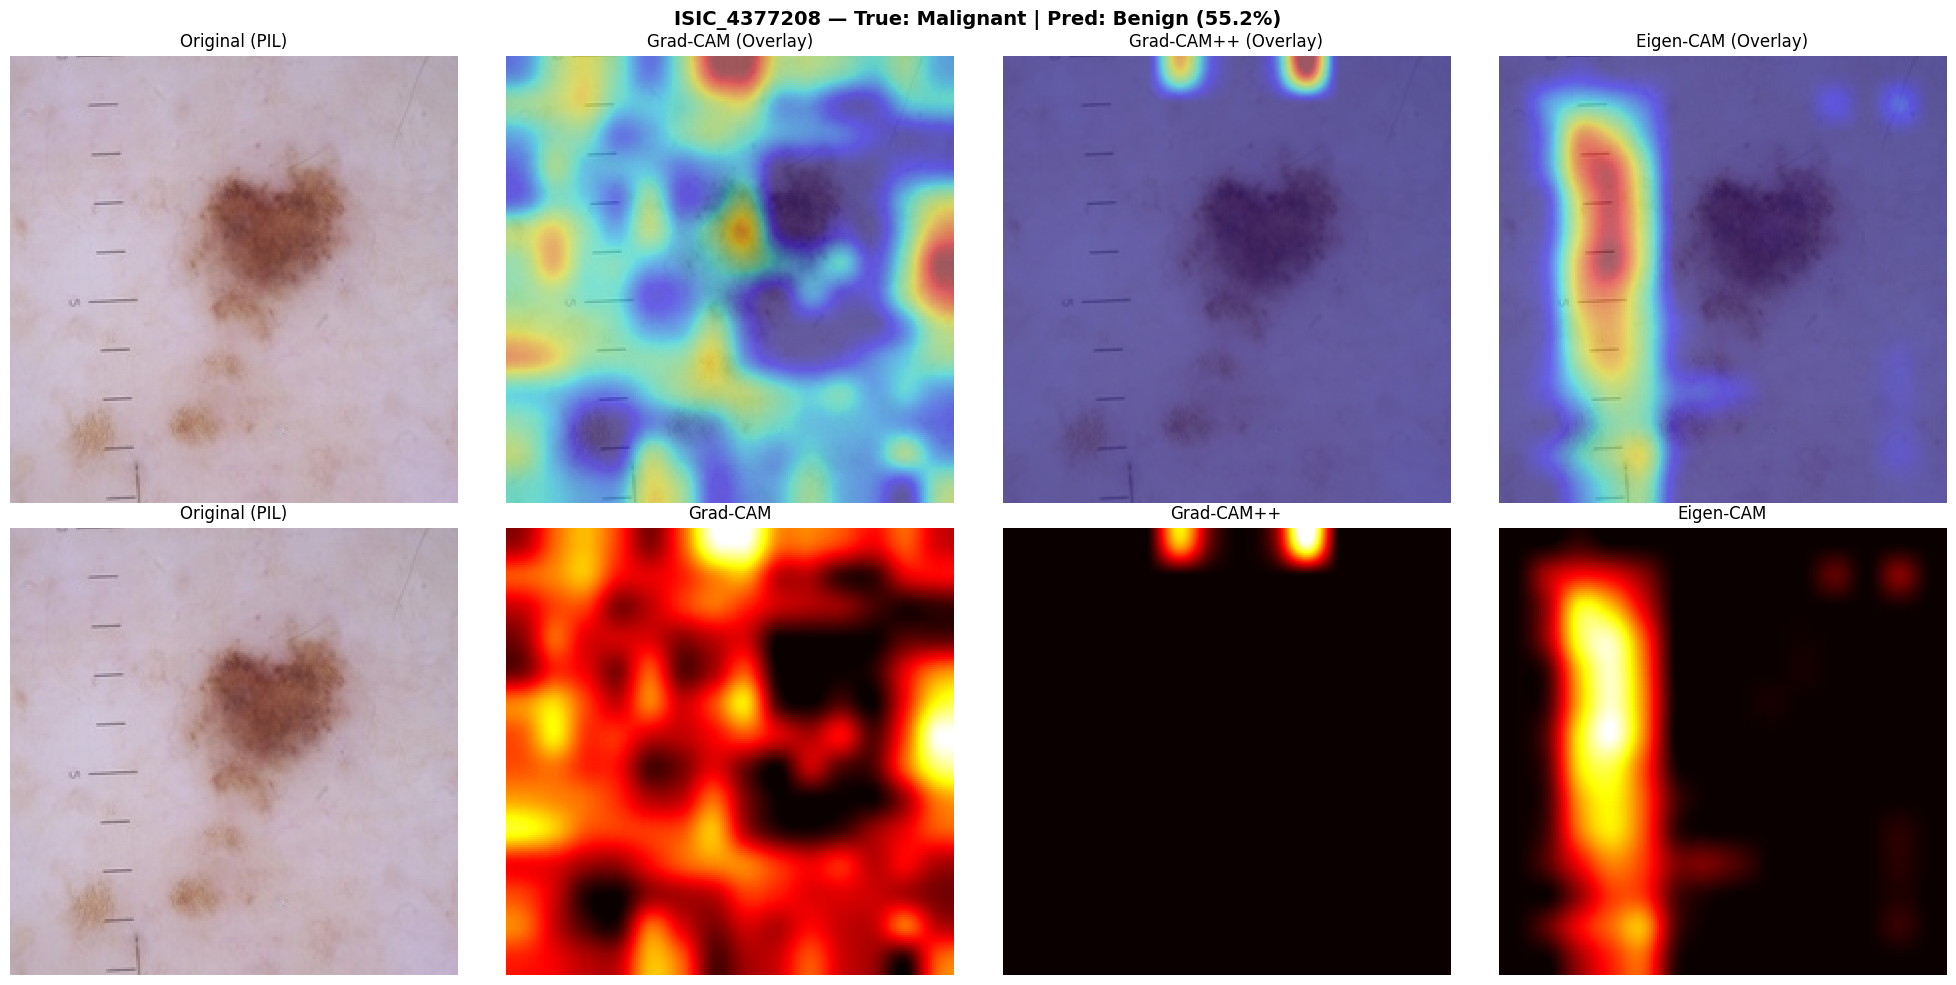

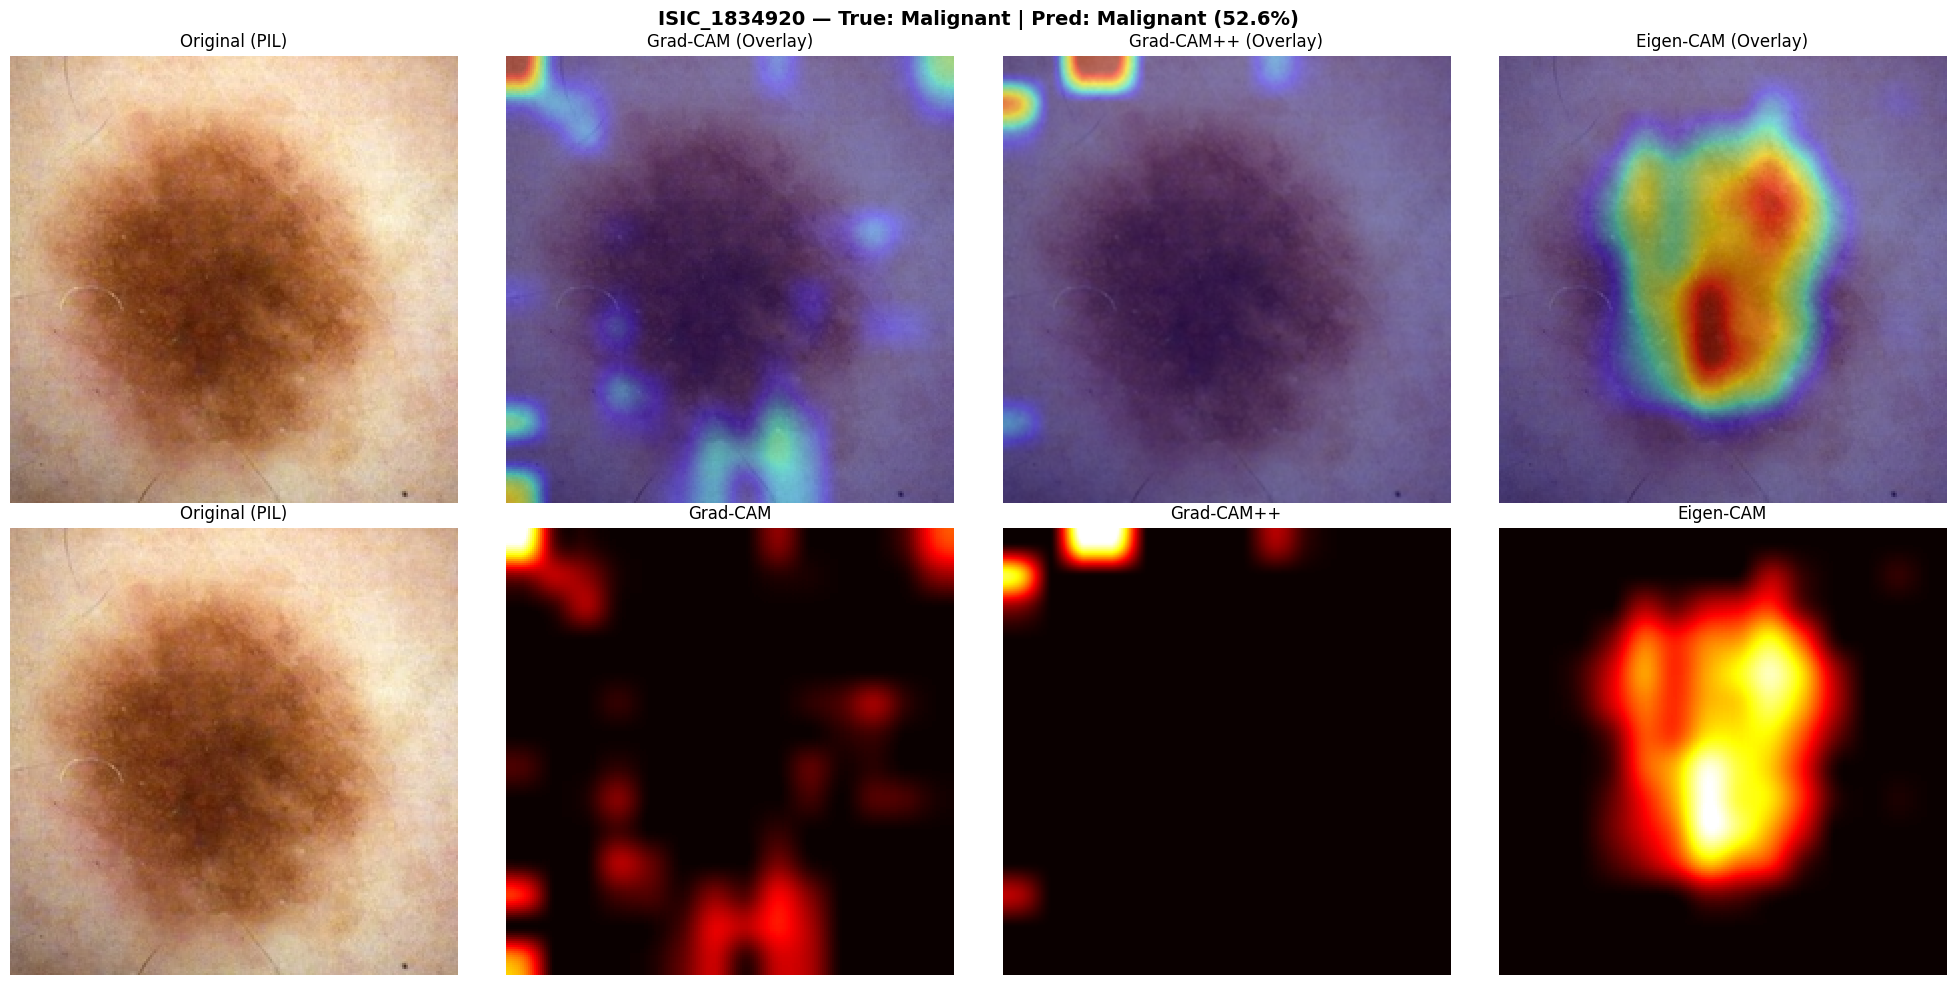

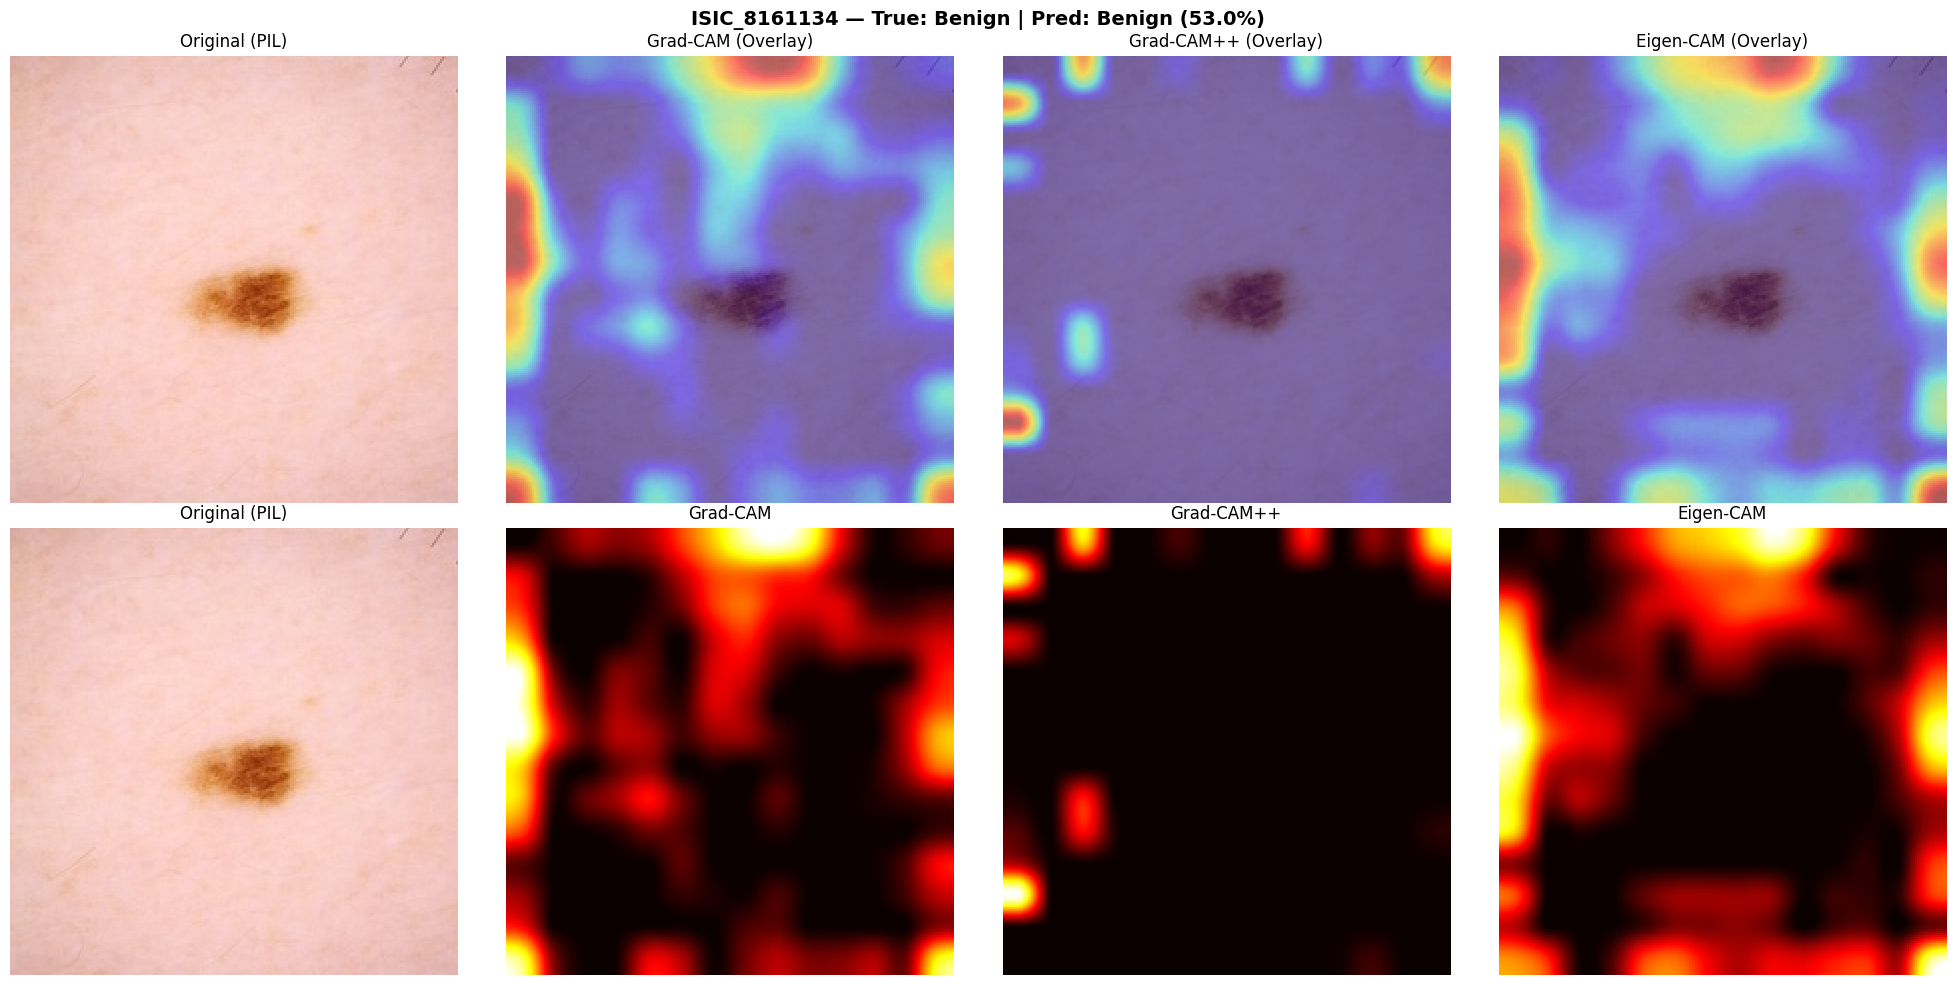

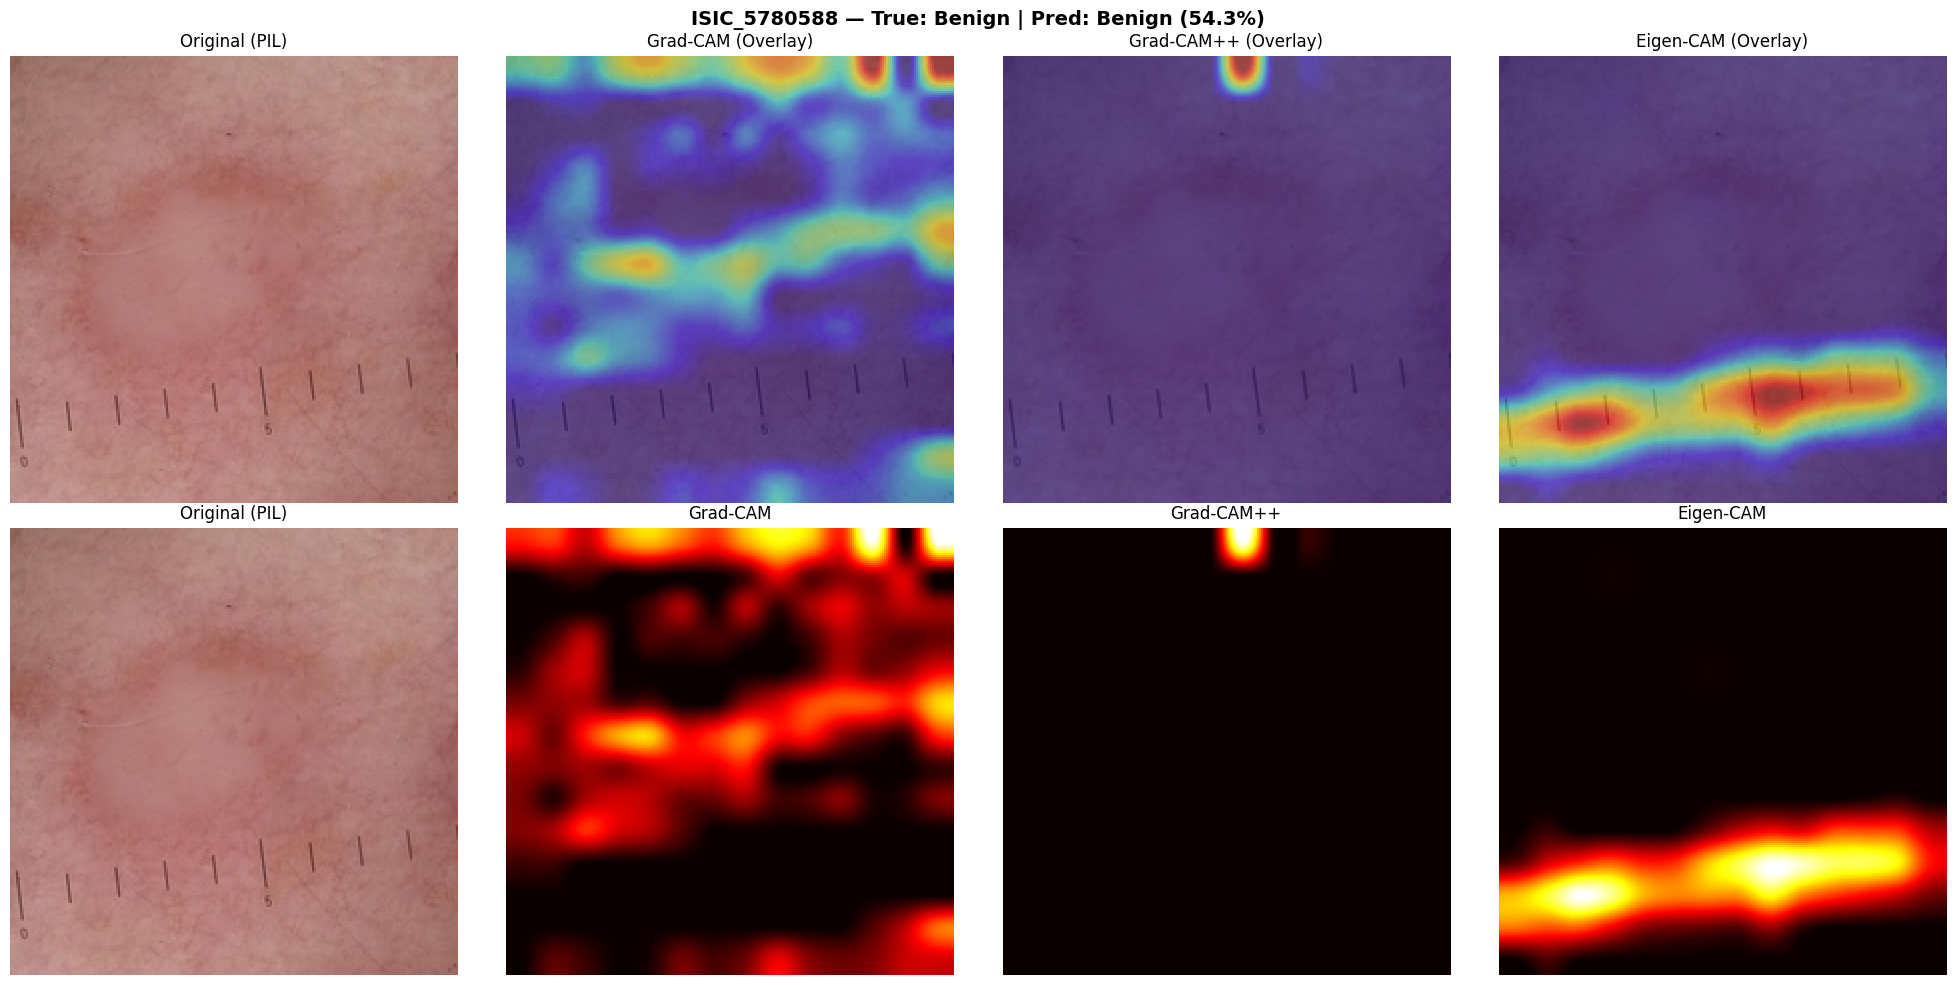


Saved figures:
 - outputs/00_ISIC_4377208.png
 - outputs/01_ISIC_1834920.png
 - outputs/02_ISIC_8161134.png
 - outputs/03_ISIC_5780588.png


In [ ]:
out_dir = Path("outputs"); out_dir.mkdir(exist_ok=True)
grad = GradCAM(model, target_layer); gpp = GradCAMPP(model, target_layer); eig = EigenCAM(model, target_layer)

saved = []
N = min(5, len(ds))
names = ["Benign", "Malignant"]

for i in range(N):
    x, y, name, pil = ds[i]
    x_ = x.unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        logits = model(x_)
        probs = torch.softmax(logits, 1)[0]
        pred = int(probs.argmax().item())
        conf = float(probs[pred].item())

    # CAMs
    with torch.enable_grad():
        cam_g  = grad(x_)
        cam_pp = gpp(x_)
    cam_e = eig(x_)

    # Overlays + raw heatmaps
    ov_g,  hm_g  = overlay(x_, cam_g)
    ov_pp, hm_pp = overlay(x_, cam_pp)
    ov_e,  hm_e  = overlay(x_, cam_e)

    # --- Plotting: originals + overlays + heatmaps ---
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle(
        f"{name} — True: {names[y]} | Pred: {names[pred]} ({conf:.1%})",
        fontsize=14, fontweight="bold"
    )

    # Row 1 — original + overlays
    axes[0,0].imshow(pil);   axes[0,0].set_title("Original (PIL)");         axes[0,0].axis("off")
    axes[0,1].imshow(ov_g);  axes[0,1].set_title("Grad-CAM (Overlay)");     axes[0,1].axis("off")
    axes[0,2].imshow(ov_pp); axes[0,2].set_title("Grad-CAM++ (Overlay)");   axes[0,2].axis("off")
    axes[0,3].imshow(ov_e);  axes[0,3].set_title("Eigen-CAM (Overlay)");    axes[0,3].axis("off")

    # Row 2 — original + raw heatmaps
    axes[1,0].imshow(pil);   axes[1,0].set_title("Original (PIL)");         axes[1,0].axis("off")
    axes[1,1].imshow(hm_g,  cmap="hot"); axes[1,1].set_title("Grad-CAM");   axes[1,1].axis("off")
    axes[1,2].imshow(hm_pp, cmap="hot"); axes[1,2].set_title("Grad-CAM++"); axes[1,2].axis("off")
    axes[1,3].imshow(hm_e,  cmap="hot"); axes[1,3].set_title("Eigen-CAM");  axes[1,3].axis("off")

    plt.tight_layout()
    path = out_dir / f"{i:02d}_{name}.png"
    fig.savefig(path, dpi=150, bbox_inches="tight")  # save first
    plt.show()
    plt.close(fig)

    saved.append(str(path))

# Clean up hooks
grad.close(); gpp.close(); eig.close()

print("\nSaved figures:")
for p in saved:
    print(" -", p)

### CAM Interpretations
Grad-CAM provides broad, diffuse heatmaps, Grad-CAM++ produces highly localized but often sparse activations, and Eigen-CAM tends to show smoother, more structured global patterns.  

- **ISIC_4377208 (Malignant, misclassified as benign)**: All CAMs misfocus, with Eigen-CAM strongly fixating on the ruler rather than lesion, matching the wrong prediction.  

- **ISIC_5780588 (Benign, correct pred)**: Activations are noisy; Eigen-CAM highlights ruler artifacts rather than the lesion, showing a mistaken focus.  
- **ISIC_8161134 (Benign, correct pred)**: Grad-CAM spreads across background; Grad-CAM++ is weak; Eigen-CAM centers on lesion, though inconsistently.  
- **ISIC_1834920 (Malignant, correct pred)**: Only Eigen-CAM clearly captures lesion shape; Grad-CAM methods are diffuse or irrelevant.  


### Significance
These results show inconsistent lesion localization and frequent reliance on artifacts. Correct predictions often stem from weak or irrelevant cues, and misclassifications confirm the model’s dependence on dataset bias.  

### Implication
The model lacks reliable medical interpretability: explanations reveal shortcut learning on rulers/backgrounds rather than pathology. Without better curation and training, deployment risks systematic failure in real-world clinical settings.  


Key takeaway: Grad-CAM and Grad-CAM++ highlighted only a thin portion of the lesion while missing irregular margins that are clinically important. Conversely, Eigen-CAM frequently spread its attention over the entire image, including background skin, suggesting the model was not restricted to lesion-specific features. One benign image was predicted malignant with high confidence, yet all three CAMs emphasized diffuse skin texture outside the lesion rather than the lesion itself. The model is likely to be learning false correlations.

## 5) Quantitative comparison
I'm computing coverage (how much of the image is highlighted), concentration (how focused the activation is), and center focus.

In [ ]:
def heatmap_metrics(cam):
    H,W = cam.shape
    c = cam[H//4:3*H//4, W//4:3*W//4]  # relative center
    return {
        "mean_activation": float(np.mean(cam)),
        "max_activation":  float(np.max(cam)),
        "coverage@0.3":    float((cam > 0.3).mean()),
        "concentration":   float(((cam > 0.7).sum()) / ((cam > 0.3).sum() + 1e-8)),
        "center_focus":    float(c.mean() / (cam.mean() + 1e-8)),
    }

def binarize(cam, t=0.3): return (cam > t).astype(np.uint8)
def iou(a, b):
    inter = (a & b).sum()
    union = (a | b).sum() + 1e-8
    return inter / union


,mean_activation,coverage@0.3,concentration,center_focus
method,,,,
Eigen-CAM,0.151,0.213,0.279,1.359
GradCAM,0.179,0.245,0.124,0.714
GradCAM++,0.016,0.017,0.732,0.006


Estimated inter-method variation: 92.8%


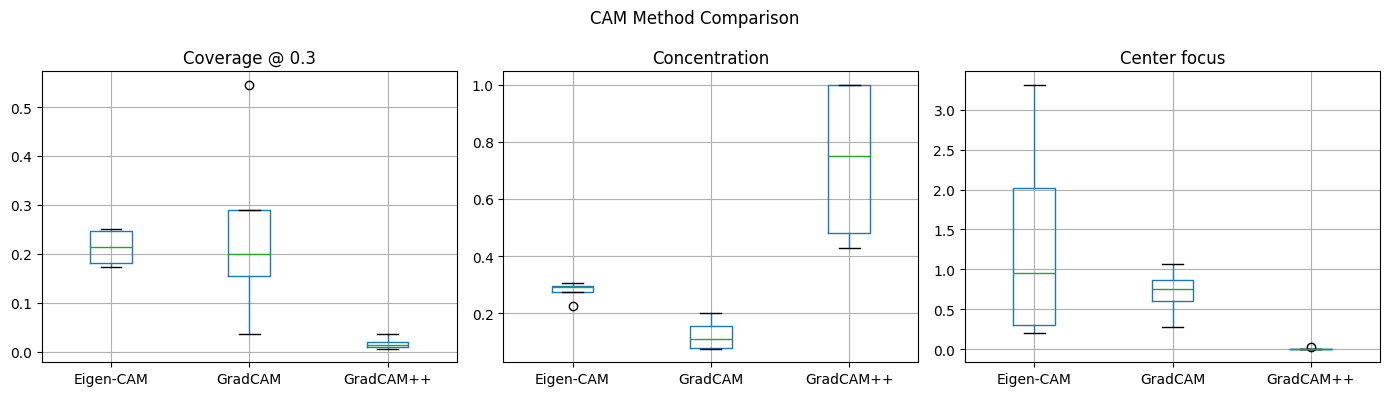

In [ ]:
grad2=GradCAM(model,target_layer); gpp2=GradCAMPP(model,target_layer); eig2=EigenCAM(model,target_layer)
metrics_rows=[]; variation_list=[]
N=min(5,len(ds))

for i in range(N):
    x,y,name,pil=ds[i]; x_=x.unsqueeze(0).to(device)
    with torch.no_grad():
        logits=model(x_); probs=torch.softmax(logits,1)[0]
        pred=int(probs.argmax().item()); conf=float(probs[pred].item())
    with torch.enable_grad():
        cam_g = grad2(x_); cam_pp = gpp2(x_)
    cam_e = eig2(x_)

    for method, cam in [("GradCAM",cam_g),("GradCAM++",cam_pp),("Eigen-CAM",cam_e)]:
        m=heatmap_metrics(cam); m.update(image=name,true=y,pred=pred,conf=conf,method=method)
        metrics_rows.append(m)

    Bg,Bpp,Be = binarize(cam_g),binarize(cam_pp),binarize(cam_e)
    variation = 100*(1-np.mean([iou(Bg,Bpp), iou(Bg,Be), iou(Bpp,Be)]))
    variation_list.append(variation)

    del x,x_,logits,probs,cam_g,cam_pp,cam_e,Bg,Bpp,Be
    if torch.cuda.is_available(): torch.cuda.empty_cache()
    gc.collect()

grad2.close(); gpp2.close(); eig2.close()

df_metrics = pd.DataFrame(metrics_rows)
display(df_metrics.groupby("method")[["mean_activation","coverage@0.3","concentration","center_focus"]].mean().round(3))

variation_mean = float(np.mean(variation_list)) if variation_list else float("nan")
print(f"Estimated inter-method variation: {variation_mean:.1f}%")

fig, axes = plt.subplots(1,3,figsize=(14,4))
df_metrics.boxplot(column="coverage@0.3", by="method", ax=axes[0]); axes[0].set_title("Coverage @ 0.3")
df_metrics.boxplot(column="concentration", by="method", ax=axes[1]); axes[1].set_title("Concentration")
df_metrics.boxplot(column="center_focus", by="method", ax=axes[2]); axes[2].set_title("Center focus")
for ax in axes: ax.set_xlabel("")
plt.suptitle("CAM Method Comparison"); plt.tight_layout(); plt.show()

# Took ChatGPT5's suggestion at 12:00 am on Oct 3 to add a lightweight quantitative module: coverage, concentration, center_focus (relative window), and IoU-based variation across methods.


## Interpretation of CAM Method Comparison

### Definitions
- **Coverage @ 0.3**: Fraction of the image area where activation values exceed a threshold of 0.3. Higher coverage means the method highlights broader regions.  
- **Concentration**: How tightly the activation is distributed within the highlighted region. High concentration = focused signal in fewer pixels.  
- **Center Focus**: Degree to which activations are biased toward the center of the image. A high score means the CAM tends to emphasize central regions.  
- **Mean Activation**: Average intensity of the activation map, a measure of overall signal strength.

### Observations
- **Coverage**: Eigen-CAM (≈0.21) and GradCAM (≈0.25) highlight moderate areas, while GradCAM++ (≈0.02) barely covers any region.  
- **Concentration**: GradCAM++ shows very high concentration (≈0.73), suggesting a sharp, localized focus. Eigen-CAM is more diffuse (≈0.28), and GradCAM sits in between (≈0.12).  
- **Center Focus**: Eigen-CAM has the strongest center bias (≈1.36), GradCAM is modestly center-biased (≈0.71), while GradCAM++ is essentially non-central (≈0.01).  
- **Mean Activation**: GradCAM has the highest average intensity (≈0.18), Eigen-CAM is slightly lower (≈0.15), and GradCAM++ is very weak overall (≈0.02).
- The heatmaps are broadly consistent with the quantitative metrics. Eigen-CAM shows the widest and most centrally biased activation, aligning with its high coverage (≈0.21 to 0.51 depending on threshold) and strong center_focus values. Grad-CAM, while diffuse in visualization, corresponds to its intermediate coverage (0.17 to 0.25) and moderate center bias (1.0). Grad-CAM++ heatmaps are often extremely sparse, consistent with its very low coverage (0.01 to 0.10) but high concentration ~0.7), reflecting sharp, selective attention. However, the qualitative review also highlights instability: Grad-CAM++ sometimes fires on image borders or ruler marks, which the metrics do not penalize. This underscores the need to interpret quantitative scores alongside visual inspection.


### Implications
- **Eigen-CAM**: Produces broad, center-weighted maps—useful for capturing overall context, but may overgeneralize.  
- **GradCAM**: Balanced method with decent coverage, moderate focus, and moderate center bias—good for general interpretability.  
- **GradCAM++**: Extremely sharp and selective, but at the cost of very limited coverage—may miss important regions if features are spread out.  
- **Overall**: The 92.8% inter-method variation indicates that the choice of CAM method has a strong impact on interpretation. Eigen-CAM emphasizes global context, GradCAM offers a balanced trade-off, and GradCAM++ prioritizes precision over completeness.


## Reflection

### 1. What the model attends to
The three CAM variants reveal distinct “styles” of attention.  
- **Eigen-CAM** spreads activation broadly across the lesion, consistent with high coverage and center bias. This suggests the backbone relies on overall lesion tone and texture.  
- **Grad-CAM** is more diffuse and weakly centered, indicating sensitivity to global image context without crisp localization.  
- **Grad-CAM++** produces the sharpest maps, highlighting borders or internal pigment structures when effective, which are clinically meaningful features under ABCDE criteria (asymmetry, border, color, diameter, evolution).

### 2. Surprising or misleading behaviors
Two failure modes emerged.  
- **Artifact sensitivity**: Grad-CAM++ frequently locks onto non-lesion structures (ruler marks, illumination bands), diverting attention away from the lesion.  
- **High inter-method variability**: Quantitatively, inter-method IoU disagreement is ~93 to 94%, and qualitatively, the three CAMs disagree on lesion coverage. This, combined with borderline class probabilities (50%), suggests the model leverages acquisition artifacts and contextual noise rather than stable melanoma-specific signals. Such behaviors raise safety concerns for clinical deployment.

### 3. Why explainability matters here
Explainability exposes hidden risks in otherwise “correct” predictions. Without heatmaps, a clinician might trust a benign/malignant label at face value, unaware it was influenced by rulers or borders. With CAMs, we can:  
1. Diagnose dataset/pipeline issues (e.g., crop lesions, remove rulers/hair, normalize lighting).  
2. Enforce cross-method consensus as a safeguard (flag cases with high disagreement).  
3. Build clinician trust by showing when attention aligns with ABCDE features.  

In medical AI, failure modes are costly. If CAMs systematically highlight irrelevant artifacts, predictions—even when correct—can mislead clinicians, risking overdiagnosis, unnecessary biopsies, or overlooked malignancies.